# Learning models and meta model with TimeSeriesSplit
### kolla artiklar om stacking, cv för stacking samt cv för stacking av timeseries 
- https://machinelearningmastery.com/implementing-stacking-scratch-python/   (Även kod i Pieces)  
Även allmänt om stacking ensembles  
- https://machinelearningmastery.com/essence-of-stacking-ensembles-for-machine-learning/  
Slutligen CV för Timeseries stacking  (se kod i Pieces)  
- https://datascience.stackexchange.com/questions/41378/how-to-apply-stacking-cross-validation-for-time-series-data

Beskrivning:  
- gör webscrape av omgång(ar) i omg_att_spela_link.csv
- concat nya_lopp med all_data och spara
- Lägg undan validate (V) för meta-modellen (20% av all_data)
- tscv = TimeSeriesSplit(n_splits=5) för all_data
- for splits 1-5 learn all previous split and predict next split concatenatate stepwise this will create one predict series for each model  
- create a stack with models predictions and learn meta model
- Final train on models with all data except the V
- predict on V, build stack and test the meta model
- finally learn meta model on p1-p5 plus V
 


# Generella funktioner

In [533]:
# moduler
from sklearn.ensemble import RandomForestRegressor
import sys
import pandas as pd
import numpy as np
import pickle
from catboost import CatBoostClassifier, Pool, cv
from IPython.display import display
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', 200)
from sklearn.model_selection import TimeSeriesSplit

sys.path.append(
    'C:\\Users\\peter\\Documents\\MyProjects\\PyProj\\Trav\\spel\\')

import typ as tp

pref = '../'

Web scraping

In [534]:
# web scraping plus fixa_mera   
# concatenate with all_data
# remove duplicates and save to all_data.csv

Preparera data

In [535]:
def remove_features(df_, remove_mer=[]):
    df = df_.copy()
    df.drop(['startnr', 'vodds', 'podds', 'bins', 'h1_dat',
             'h2_dat', 'h3_dat', 'h4_dat', 'h5_dat'], axis=1, inplace=True)
    if remove_mer:
        df.drop(remove_mer, axis=1, inplace=True)

    return df

In [536]:

# Förbered för learning
def förbered(df,meta_procent):
    # Följande datum saknar avd==5 och kan inte användas
    saknas = ['2015-08-15', '2016-08-13', '2017-08-12']
    df = df[~df.datum.isin(saknas)]
    X = df.copy()
    X.drop('plac', axis=1, inplace=True)
    
    # läs in FEATURES.txt
    with open(pref+'FEATURES.txt', 'r',encoding='utf-8') as f:    
        features = f.read().splitlines()
     
    X=X[features]
    
    assert len(features) == len(X.columns), f'features {len(features)} and X.columns {len(X.columns)} are not the same length'   
    assert set(features) == set(X.columns), f'features {set(features)} and X.columns {set(X.columns)} are not the same'
    
    # X=remove_features(X)
    
    y = (df.plac == 1)*1   # plac 1 eller 0

    for f in ['häst', 'bana', 'kusk', 'h1_kusk', 'h2_kusk', 'h3_kusk', 'h4_kusk', 'h5_kusk', 'h1_bana', 'h2_bana', 'h3_bana', 'h4_bana', 'h5_bana']:
        X[f] = X[f].str.lower()

    X.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
   
    meta_antal = int(len(X.datum.unique())*meta_procent)
    meta_datum = X.datum.unique()[-meta_antal:]
    X_val = X.loc[X.datum.isin(meta_datum)]
    y_val = y[X_val.index]
    X=X.loc[~X.datum.isin(meta_datum)]
    y=y.loc[X.index]
    
    return X, y, X_val, y_val


In [537]:
# modellerna
#              namn, ant_hästar, proba, Kelly,  motst_ant, motst_diff, ant_favoriter,   only_clear, streck
typ6 = tp.Typ('typ6', True,       True, False,     0,       False,          0,            False,    True)
typ1 = tp.Typ('typ1', False,      True, False,     2,       True,           2,            True,     False)
typ9 = tp.Typ('typ9', True,       True, True,      2,       True,           2,            True,     True)
typ16= tp.Typ('typ16',True,       True, True,      2,       True,           2,            False,    True)

typer = [typ6, typ1, typ9, typ16]


In [538]:
# Skapa ett Kelly-värde baserat på streck omvandlat till odds
def kelly(proba, streck, odds):  # proba = prob winning, streck i % = streck
    with open(pref+'rf_streck_odds.pkl', 'rb') as f:
        rf = pickle.load(f)

    if odds is None:
        o = rf.predict(streck.copy())
    else:
        o = rf.predict(streck.copy())

    # for each values > 40 in odds set to 1
    o[o > 40] = 1
    return (o*proba - (1-proba))/o


In [539]:
def skapa_stack_learning(X_, y, save=True):
    X=X_.copy()
    stacked_data = pd.DataFrame()
    for typ in typer:
            nr = typ.name[3:]
            stacked_data['proba'+nr] = typ.predict(X)
            stacked_data['kelly' + nr] = kelly(stacked_data['proba' + nr], X[['streck']], None)

    print(stacked_data.columns)
    assert len(stacked_data) == len(y), f'stacked_data {len(stacked_data)} and y {len(y)} should have same length'
    return stacked_data,y   # enbart stack-info


Skapa data till meta model learning mha TimeSeriesSplit

In [540]:
# TimeSeriesSplit learning
def TS_learning(X_,y,typer, n_splits=5,learn_models=True):
    X=X_.copy()
    # learn_models=True betyder att vi både gör en learning och skapar en stack
    # learn_models=False betyder att vi bara skapar en stack
    print('shape X', X.shape)
    print('shape y', y.shape)
    ts = TimeSeriesSplit(n_splits=n_splits)
    stacked_data=pd.DataFrame(columns=['proba6', 'proba1', 'proba9', 'proba16', 'kelly6', 'kelly1', 'kelly9', 'kelly16','y'])
        
    for enum,(train_index, test_index) in enumerate(ts.split(X,y)):
        print('shape of X', X.shape, 'shape of X_train', X.iloc[train_index].shape, 'shape of X_test', X.iloc[test_index].shape)
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]
        temp_df = pd.DataFrame()
        temp_df['y'] =  y_test
        for typ in typer:
            print(typ.name, enum)
            if learn_models:
                typ.learn(X_train, y_train, X_test, y_test)
                
            nr = typ.name[3:]
            this_proba=typ.predict(X_test)
            
            temp_df['proba'+nr] = this_proba

            this_kelly=kelly(this_proba, X_test[['streck']], None)
            temp_df['kelly' + nr] = this_kelly
        stacked_data = pd.concat([stacked_data, temp_df],ignore_index=True)
        stacked_data.y = stacked_data.y.astype(int)
    
    return stacked_data    
### stacked_data = TS_learning(typer) #for testing

Meta model learning

In [541]:
# fit meta_model
def learn_meta_model(X, y,  save=True,
                     n_estimators=100, 
                     max_depth=None,
                     min_samples_split=2, 
                     min_samples_leaf=1, 
                     max_features='auto', 
                     max_leaf_nodes=None,
                     max_samples=None,
                     oob=False):
    from sklearn.ensemble import RandomForestClassifier

    meta_model = RandomForestClassifier(
        class_weight='balanced',    #{0:1,1:10},
        oob_score=oob, verbose=1, n_jobs=8, random_state=2022,
        max_depth=max_depth,
        n_estimators=n_estimators, 
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        max_leaf_nodes=max_leaf_nodes,
max_samples=max_samples,)
    
    meta_model.fit(X, y)
    if oob:
        print('OOB_score', meta_model.oob_score_)   # 0.9430916552667579
        
    # pickle save stacking
    if save:
        with open(pref+'modeller/meta_model.model', 'wb') as f:
            pickle.dump(meta_model, f)

    return meta_model

def predict_meta_model(X,meta_model):
    return meta_model.predict_proba(X)


Make the learning

In [542]:
df_all = pd.read_csv(pref+'all_data.csv')
X, y, X_val, y_val = förbered(df_all, meta_procent=0.2)
print('X shape',X.shape,'y shape',y.shape)
print('X_val shape',X_val.shape,'y_val shape',y_val.shape)

# learn models and produce the stacked data
stacked_data = TS_learning(X,y,typer)   

# learn meta_model
meta_model=learn_meta_model(stacked_data.drop(['y'], axis=1), stacked_data['y']) 


X shape (35686, 78) y shape (35686,)
X_val shape (8910, 78) y_val shape (8910,)
shape X (35686, 78)
shape y (35686,)
shape of X (35686, 78) shape of X_train (5951, 78) shape of X_test (5947, 78)
typ6 0
typ1 0
typ9 0
typ16 0
shape of X (35686, 78) shape of X_train (11898, 78) shape of X_test (5947, 78)
typ6 1
typ1 1
typ9 1
typ16 1
shape of X (35686, 78) shape of X_train (17845, 78) shape of X_test (5947, 78)
typ6 2
typ1 2
typ9 2
typ16 2
shape of X (35686, 78) shape of X_train (23792, 78) shape of X_test (5947, 78)
typ6 3
typ1 3
typ9 3
typ16 3
shape of X (35686, 78) shape of X_train (29739, 78) shape of X_test (5947, 78)
typ6 4
typ1 4
typ9 4
typ16 4


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.8s finished


Testa mot validatation data (X_val och y_val)

In [543]:
stacked_meta_val, y_val = skapa_stack_learning(X_val, y_val)
stacked_meta_val['meta'] = predict_meta_model(stacked_meta_val, meta_model=meta_model)[:,1]
stacked_meta_val['y'] = y_val.values
stacked_meta_val['avd'] = X_val.avd.values

def confusion_matrix_graph(y_true, y_pred, title='Confusion matrix'):
    # confusion matrix graph
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    # make a graph 
    
    import seaborn as sns
    import matplotlib.pyplot as plt
    sns.heatmap(cm, annot=True, fmt=".2f", linewidths=.5, square=True, cmap='Blues_r')
    sns.set(font_scale=2.0)
    # plt.figure(figsize=(10,10))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    plt.show()
    
def scores(y_true, y_pred):    
    # what is the AUC score?
    from sklearn.metrics import roc_auc_score
    print('AUC',roc_auc_score(y_true, y_pred))
    # and the F1 score
    from sklearn.metrics import f1_score
    print('F1',f1_score(y_true, y_pred))
    #accuracy
    from sklearn.metrics import accuracy_score
    print('Acc',accuracy_score(y_true, y_pred))


Index(['proba6', 'kelly6', 'proba1', 'kelly1', 'proba9', 'kelly9', 'proba16', 'kelly16'], dtype='object')


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


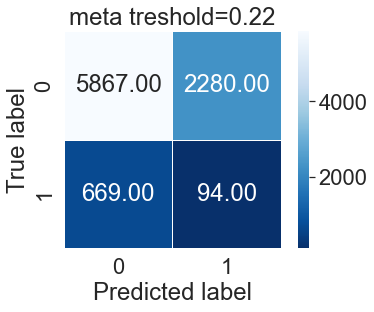

AUC 0.42167014335696906
F1 0.05992986930188078
Acc 0.6690235690235691
3.1973063973063973


In [629]:
tresh=0.22
typ='meta'
confusion_matrix_graph(stacked_meta_val['y'], (stacked_meta_val[typ]>tresh).astype(int), f'{typ} treshold={tresh}')
scores(stacked_meta_val['y'], (stacked_meta_val[typ]>tresh))
print(12*sum(stacked_meta_val[typ]>tresh)/len(stacked_meta_val))


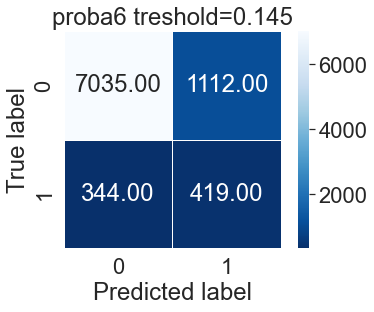

AUC 0.7063280696880277
F1 0.36530078465562343
Acc 0.83658810325477
2.0619528619528618


In [689]:
tresh=0.145
typ='proba6'
confusion_matrix_graph(stacked_meta_val['y'], (stacked_meta_val[typ]>tresh).astype(int), f'{typ} treshold={tresh}')
scores(stacked_meta_val['y'], (stacked_meta_val[typ]>tresh))
print(12*sum(stacked_meta_val[typ]>tresh)/len(stacked_meta_val))

# Final learn on all data

In [ ]:
# learn the models on all data
stacked_data = TS_learning(X,y,typer,learn_models=True)


In [509]:

meta_model=learn_meta_model(stacked_data.drop(['y'], axis=1), stacked_data['y'])    


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.7s finished


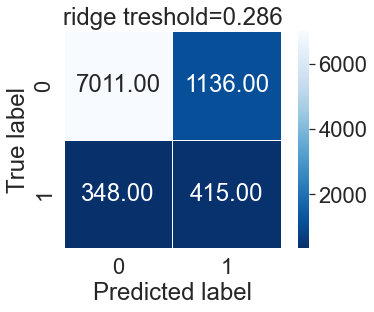

AUC 0.7022339028863636
F1 0.35868625756266204
Acc 0.8334455667789001
2.088888888888889


In [690]:
# apply ridge classifier to stacked_data
from sklearn.linear_model import RidgeClassifier
ridge_model = RidgeClassifier(random_state=2022)
ridge_model.fit(stacked_data.drop(['y'], axis=1), stacked_data['y'])
pred = ridge_model._predict_proba_lr(stacked_meta_val.iloc[:,:-3] )[:,1]
tresh=0.286
typ='ridge'
confusion_matrix_graph(stacked_meta_val['y'], pred>tresh, f'{typ} treshold={tresh}')
scores(stacked_meta_val['y'], pred>tresh)
print(12*sum(pred>tresh)/len(stacked_meta_val))

# learn on final data
ridge_model = ridge_model.fit(stacked_data.drop(['y'], axis=1), stacked_data['y'])
# save this model
with open(pref+'modeller/ridge_model.model', 'wb') as f:
    pickle.dump(ridge_model, f)


8910


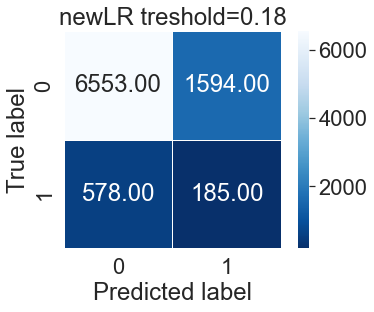

AUC 0.5234045578935295
F1 0.14555468135326516
Acc 0.7562289562289563
2.395959595959596


In [687]:

from sklearn.linear_model import LogisticRegression
# apply logistic regression on the stacked data
logreg = LogisticRegression(solver='lbfgs',
                            class_weight='balanced',
                                multi_class='auto',
                                random_state=2022,
                                max_iter=1000)
new_model = logreg.fit(stacked_data.drop(['y'], axis=1), stacked_data['y'])

# print(stacked_meta_val.iloc[:,:-3]  )
pred = new_model.predict_proba(stacked_meta_val.iloc[:,:-3] )[:,1]
# pred = new_model.predict(stacked_meta_val.iloc[:,:-3] )

print(stacked_meta_val.shape[0])
tresh=0.18
typ='newLR'
confusion_matrix_graph(stacked_meta_val['y'], pred>tresh, f'{typ} treshold={tresh}')
scores(stacked_meta_val['y'], pred>tresh)
# tresh=0
# confusion_matrix_graph(stacked_meta_val['y'], pred, f'{typ} treshold={tresh}')
# scores(stacked_meta_val['y'], pred)
print(12*sum(pred>tresh)/len(stacked_meta_val))
